# Figure 5

In [1]:
import os.path as op
import pandas as pd
import numpy as np
from sklearn import preprocessing, linear_model
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import plotutils

In [2]:
df_dir = op.join('..', 'data', 'dataframes')

In [3]:
subjects, rois, tasks = plotutils.default_data()

In [4]:
plotutils.set_plot_style()

### Load dataframes

In [5]:
params_boot = pd.read_csv(op.join(df_dir, 'group_ang_fits_boots.csv'))
params_conf = plotutils.params_ci(params_boot)

In [6]:
params_snr   = pd.read_csv(op.join(df_dir, 'sim_snr_group_ang_fits.csv'))
params_lapse = pd.read_csv(op.join(df_dir, 'sim_lapse_group_ang_fits.csv'))
params_assoc = pd.read_csv(op.join(df_dir, 'sim_assoc_group_ang_fits.csv'))
params_ang   = pd.read_csv(op.join(df_dir, 'sim_ang_group_ang_fits.csv'))

### Count simulations falling within memory CI and define plot style

In [7]:
def count_sims(params_sim, sim_var, params_conf):
    
    # Melt params
    params_sim = params_sim.melt(id_vars=['task', 'roi', 'simulation', sim_var], 
                                 var_name='param', value_vars=['loc_deg', 'amp', 'fwhm_deg'])
    
    # Loop over roi and params 
    counts = []
    for (v, r, p), g in params_sim.groupby([sim_var, 'roi', 'param']):
        
        # Get CI and count proportion of sims in it
        ci  = params_conf.query("roi==@r & param==@p")['ci'].values[0]
        in_ci = np.logical_and(g['value'] >= ci[0], g['value'] <= ci[1])
        prop = np.sum(in_ci)/len(g['simulation'].unique())
        
        # Save data
        sdf = pd.DataFrame(dict(roi=r, prop=prop, param=p), index=[0])
        sdf[sim_var] = v
        counts.append(sdf)

    counts = pd.concat(counts).reset_index(drop=True)

    return counts

In [8]:
def plot_sim_counts(xvar, xticklabels, xlabel, data):

    g = sns.catplot(x=xvar, y='prop', hue='roi', col='param', col_order=['loc_deg', 'fwhm_deg'],  
                    hue_order=rois, palette=roi_pal, kind='point', dodge=True, 
                    join=True, legend=False, height=4.5, aspect=.9, data=data)
    
    g.set_xticklabels(xticklabels)
    g.set_xlabels(xlabel)
    g.set_ylabels('Proportion of simulations\nwithin memory CI')
    for p, ax in zip(['Location', 'FWHM'], g.axes.flatten()):
        ax.set_title(p)
        
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(handles, rois, loc='center left', frameon=False, title='', 
                    handletextpad=0, bbox_to_anchor=(1, 0.7))
    
    sns.despine(trim=True)
    plt.gcf().tight_layout(w_pad=1)

### Figure 5a

In [9]:
params_conf_mem = params_conf.query("task=='memory' & conf_level==95")

roi_pal = ['#c44e52', '#dd8452', '#ccb974', '#55a868', '#4c72b0', '#8172b3']

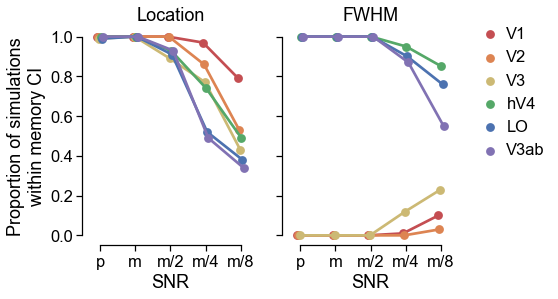

In [10]:
snr_counts = count_sims(params_snr, 'noise_factor', params_conf_mem)
plot_sim_counts('noise_factor', ['p', 'm', 'm/2', 'm/4', 'm/8'], 'SNR', snr_counts)

### Figure 5b

In [11]:
lapse_counts = count_sims(params_lapse, 'nlapse', params_conf_mem)

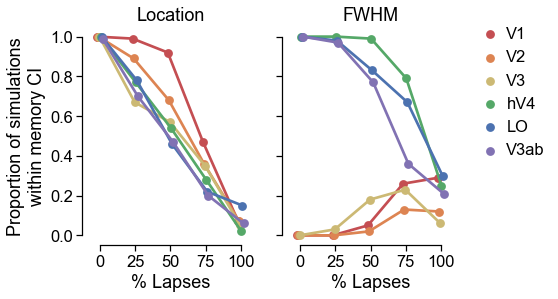

In [12]:
plot_sim_counts('nlapse', [0, 25, 50, 75, 100], '% Lapses', lapse_counts)

### Figure 5c

In [13]:
assoc_counts = count_sims(params_assoc, 'n_assoc_err', params_conf_mem)

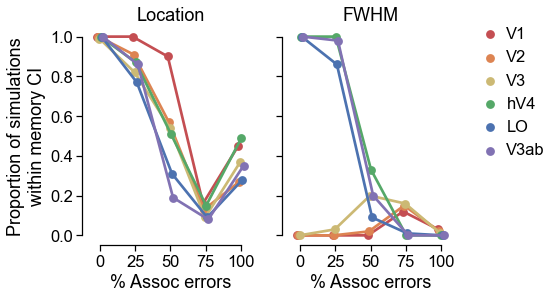

In [14]:
plot_sim_counts('n_assoc_err', [0, 25, 50, 75, 100], '% Assoc errors', assoc_counts)

### Figure 5d

In [15]:
ang_counts = count_sims(params_ang, 'err_std', params_conf_mem)

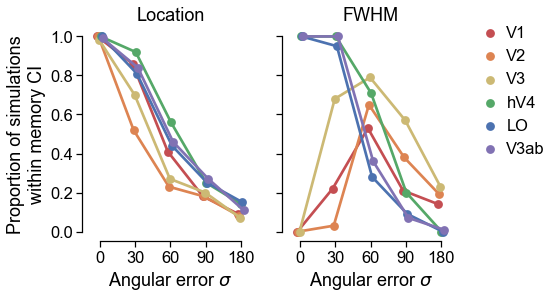

In [16]:
plot_sim_counts('err_std', [0, 30, 60, 90, 180], 'Angular error $\\sigma$', ang_counts)